Colab Link: https://colab.research.google.com/drive/1wiBQ0M9Zo97UC47pB93mt0zhekp7bmTb?usp=sharing#scrollTo=toKevJmBGvbm

# **Predicting the Price of Airbnb Listings in London**

**Group A7**
- Asra Ahmed
- Jenil Shah
- Sneha Jayapradeep
- Chirayu Jain

# 1. Introduction and Motivation

With a rising popularity of tourists choosing Airbnbs over hotels, our team wanted to do a deep dive into predicting Airbnb prices for listings based in London. As Airbnb users ourselves, we have always been intrigued by understanding how the prices are determined by hosts/Airbnb itself. We feel that this is an important business problem because using an ML model to predict prices vs. letting hosts/Airbnb 'make up' prices leads to transparency, a more efficient/competitive marketplace, a more enjoyable experience for users and therefore an increase in Airbnb usage (leading to increased revenues).

Through this project we are hoping to find a supervised ML model that predicts Airbnb prices well so that a company like Airbnb could regulate pricing, especially in a popular city like London, leading to improvements in pricing strategies, enhacement of user experiences, and gaining valuable market insights.

# 2. Importing Libraries, Mounting the Drive, and Loading the Dataset

In [ ]:
pip install geohash2

## 2.1 Importing Libraries

In [ ]:
from google.colab import drive

import ipywidgets as widgets
from IPython.display import display
import geohash2 as gh
from scipy.stats import randint, loguniform

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import geopandas as gpd

from sklearn.experimental import enable_halving_search_cv
from sklearn import set_config
from sklearn import linear_model
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, cross_validate, cross_val_score, HalvingRandomSearchCV
from sklearn.metrics import mean_squared_error, mean_squared_error, mean_absolute_error, r2_score
from sklearn.svm import SVR
from scipy.stats import uniform, randint
from sklearn.preprocessing import scale, StandardScaler, OneHotEncoder, FunctionTransformer, PowerTransformer, RobustScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.model_selection import KFold, cross_val_score

## 2.2 Mounting the Drive and Loading the Dataset

In [ ]:
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
pd.set_option('display.float_format', lambda x: '%.5f' % x) # suppressing scientific notation
listings = pd.read_csv('/content/gdrive/MyDrive/BA-810-Project/listings.csv')

# 3. Quick Exploration and Data Cleaning

## 3.1 Exploring the data a bit

In [ ]:
listings.head()

,index,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,0,13913,Holiday London DB Room Let-on going,54730,Alina,NaN,Islington,51.56802,-0.11121,Private room,65,1,16,6/10/2019,0.15000,3,347
1,1,15400,Bright Chelsea Apartment. Chelsea!,60302,Philippa,NaN,Kensington and Chelsea,51.48796,-0.16898,Entire home/apt,100,3,85,5/5/2019,0.73000,1,203
2,2,17402,Superb 3-Bed/2 Bath & Wifi: Trendy W1,67564,Liz,NaN,Westminster,51.52098,-0.14002,Entire home/apt,300,3,41,6/19/2019,0.41000,14,269
3,3,24328,Battersea bedroom & office w parking shared ga...,41759,Joe,NaN,Wandsworth,51.47298,-0.16376,Entire home/apt,175,30,93,6/8/2019,0.88000,1,329
4,4,25023,All-comforts 2-bed flat near Wimbledon tennis,102813,Amanda,NaN,Wandsworth,51.44687,-0.21874,Entire home/apt,65,4,28,6/22/2019,0.69000,1,2


In [ ]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83850 entries, 0 to 83849
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   index                           83850 non-null  int64  
 1   id                              83850 non-null  int64  
 2   name                            83824 non-null  object 
 3   host_id                         83850 non-null  int64  
 4   host_name                       83803 non-null  object 
 5   neighbourhood_group             0 non-null      float64
 6   neighbourhood                   83850 non-null  object 
 7   latitude                        83850 non-null  float64
 8   longitude                       83850 non-null  float64
 9   room_type                       83850 non-null  object 
 10  price                           83850 non-null  int64  
 11  minimum_nights                  83850 non-null  int64  
 12  number_of_reviews               

we can see that the last couple columns have null values, as well as neighbourhood_group, which is entirely null. We will most likely remove this column.

In [ ]:
listings.describe()

,index,id,host_id,neighbourhood_group,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,83850.00000,83850.00000,83850.00000,0.00000,83850.00000,83850.00000,83850.00000,83850.00000,83850.00000,62827.00000,83850.00000,83850.00000
mean,41924.50000,21348195.55924,78228741.86875,NaN,51.50950,-0.12839,121.65630,4.20196,16.48432,1.20837,25.59950,116.32784
std,24205.55437,10283563.80740,78234945.98052,NaN,0.04624,0.09223,224.90015,16.07044,34.89266,1.41684,137.24055,132.40335
min,0.00000,13913.00000,2010.00000,NaN,51.29272,-0.50130,0.00000,1.00000,0.00000,0.00000,1.00000,0.00000
25%,20962.25000,13649324.25000,14517363.00000,NaN,51.48524,-0.18839,45.00000,1.00000,0.00000,0.24000,1.00000,0.00000
50%,41924.50000,22009272.50000,44512477.00000,NaN,51.51397,-0.12581,81.00000,2.00000,4.00000,0.74000,1.00000,55.00000
75%,62886.75000,30315537.75000,132581311.00000,NaN,51.53740,-0.07037,140.00000,3.00000,17.00000,1.64000,4.00000,229.00000
max,83849.00000,36585818.00000,274979066.00000,NaN,51.68657,0.29657,13700.00000,1125.00000,665.00000,30.93000,1161.00000,365.00000


## 3.2 Data Cleaning

### 3.2.1 Dropping neighbourhood_group

In [ ]:
listings = listings.drop("neighbourhood_group", axis=1)
listings

,index,id,name,host_id,host_name,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,0,13913,Holiday London DB Room Let-on going,54730,Alina,Islington,51.56802,-0.11121,Private room,65,1,16,6/10/2019,0.15000,3,347
1,1,15400,Bright Chelsea Apartment. Chelsea!,60302,Philippa,Kensington and Chelsea,51.48796,-0.16898,Entire home/apt,100,3,85,5/5/2019,0.73000,1,203
2,2,17402,Superb 3-Bed/2 Bath & Wifi: Trendy W1,67564,Liz,Westminster,51.52098,-0.14002,Entire home/apt,300,3,41,6/19/2019,0.41000,14,269
3,3,24328,Battersea bedroom & office w parking shared ga...,41759,Joe,Wandsworth,51.47298,-0.16376,Entire home/apt,175,30,93,6/8/2019,0.88000,1,329
4,4,25023,All-comforts 2-bed flat near Wimbledon tennis,102813,Amanda,Wandsworth,51.44687,-0.21874,Entire home/apt,65,4,28,6/22/2019,0.69000,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83845,83845,36583878,7 VH Loft Apartment,90770681,Sara,Westminster,51.53057,-0.18423,Entire home/apt,100,2,0,NaN,NaN,1,209
83846,83846,36584535,Lambs Passage 1 Bedroom Apartment,47609036,Ben,Islington,51.52301,-0.08979,Entire home/apt,82,14,0,NaN,NaN,18,35
83847,83847,36585425,1 Bedroom Apartment in Lambs Passage,47609036,Ben,Islington,51.52301,-0.08979,Entire home/apt,78,21,0,NaN,NaN,18,36
83848,83848,36585645,Lambs Passage 1 Bedroom,47609036,Ben,Islington,51.52301,-0.08979,Entire home/apt,82,21,0,NaN,NaN,18,36


### 3.2.2 Converting neighbourhood to a 'Category'

In [ ]:
listings['neighbourhood'].nunique()
listings['neighbourhood'] = listings['neighbourhood'].astype('category')

### 3.3.3 Converting last_review to datetime format

In [ ]:
listings['last_review'] = pd.to_datetime(listings['last_review'])
most_recent_date = listings['last_review'].max()
print(most_recent_date)
oldest_date = listings['last_review'].min()
print(oldest_date)

2019-07-11 00:00:00
2011-07-02 00:00:00


### 3.3.4 Handling all the null values

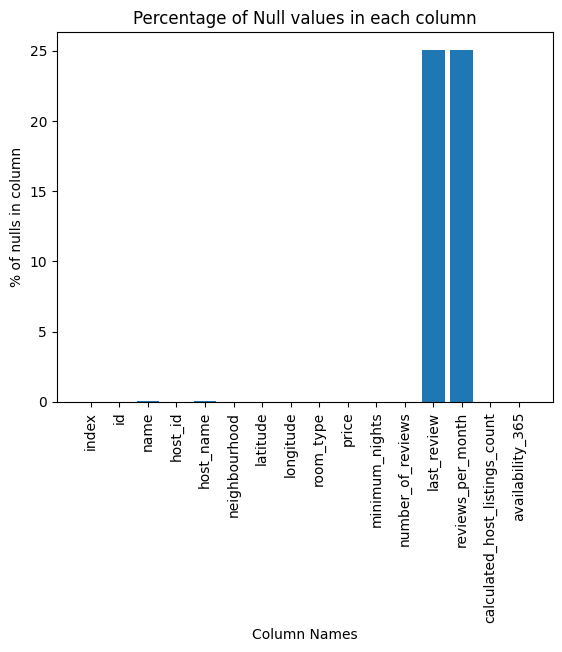

In [ ]:
null_percentage =  listings.isna().sum() / listings.shape[0] * 100
fig, ax = plt.subplots()
bars = ax.bar(x = listings.columns, height=round(null_percentage, 2))
ax.tick_params(axis='x', rotation=90)
ax.tick_params(axis='y')
plt.title("Percentage of Null values in each column")
plt.xlabel("Column Names")
plt.ylabel("% of nulls in column")
plt.show()

The following columns appear to have nulls:
1. name
2. host_name
3. last_review
4. reviews_per_month

### 3.3.5 Imputing null values in 'last_review' column

We are finding the oldest date in the dataset, and setting the date for all the null values in last_review as an even older data that we have decided to be 1/1/2010

In [ ]:
listings['last_review'] = pd.to_datetime(listings['last_review'], errors='coerce')
listings['last_review'].min()

Timestamp('2011-07-02 00:00:00')

In [ ]:
listings['last_review'] = listings['last_review'].fillna(pd.to_datetime('2010-01-01 00:00:00'))

### 3.3.6 Imputing null values in 'reviews_per_month' column

We are replacing missing values in 'reviews_per_month' with the calculated median

In [ ]:
median_reviews_per_month = listings['reviews_per_month'].median()
listings['reviews_per_month'].fillna(median_reviews_per_month, inplace=True)

### 3.3.7 Imputing null values in 'name' and 'host_name' columns with 'Unknown'

In [ ]:
listings['name'] = listings['name'].fillna('Unknown')
listings['host_name'] = listings['host_name'].fillna('Unknown')

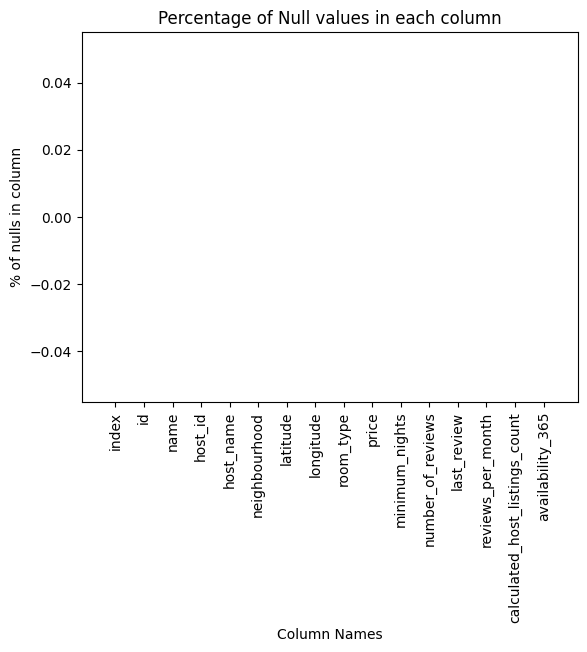

In [ ]:
null_percentage =  listings.isna().sum() / listings.shape[0] * 100
fig, ax = plt.subplots()
bars = ax.bar(x = listings.columns, height=round(null_percentage, 2))
ax.tick_params(axis='x', rotation=90)
ax.tick_params(axis='y')
plt.title("Percentage of Null values in each column")
plt.xlabel("Column Names")
plt.ylabel("% of nulls in column")
plt.show()

All the null values have been taken care of.

In [ ]:
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83850 entries, 0 to 83849
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype         
---  ------                          --------------  -----         
 0   index                           83850 non-null  int64         
 1   id                              83850 non-null  int64         
 2   name                            83850 non-null  object        
 3   host_id                         83850 non-null  int64         
 4   host_name                       83850 non-null  object        
 5   neighbourhood                   83850 non-null  category      
 6   latitude                        83850 non-null  float64       
 7   longitude                       83850 non-null  float64       
 8   room_type                       83850 non-null  object        
 9   price                           83850 non-null  int64         
 10  minimum_nights                  83850 non-null  int64         
 11  nu

# 4. EDA to Understand Features for Model

## 4.1 Visualizing Outliers

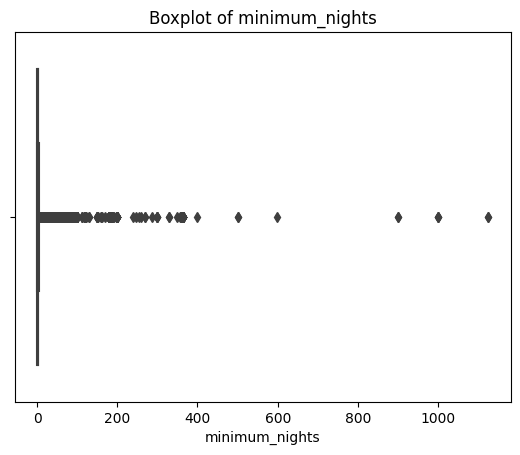

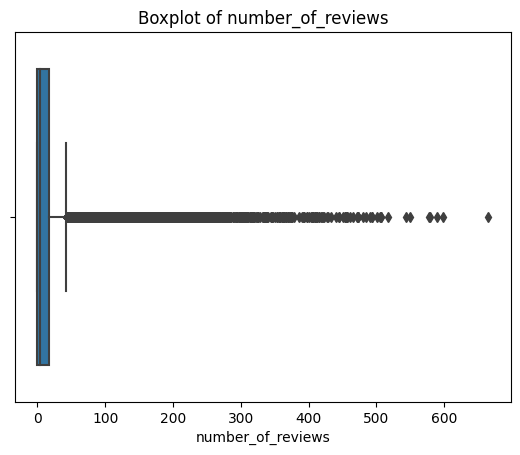

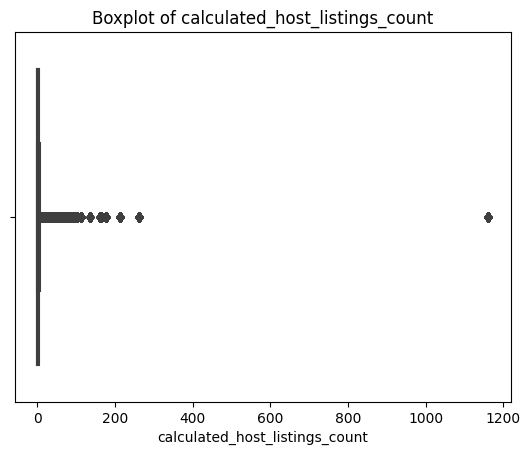

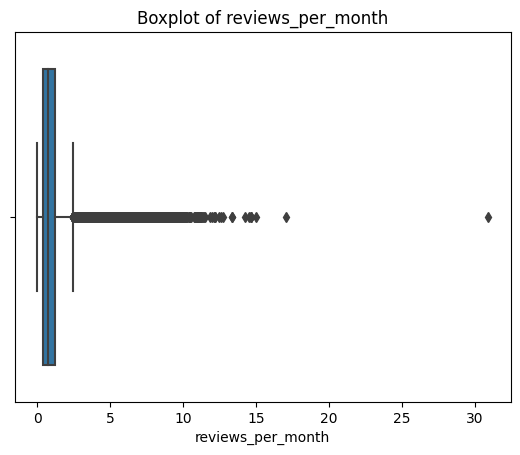

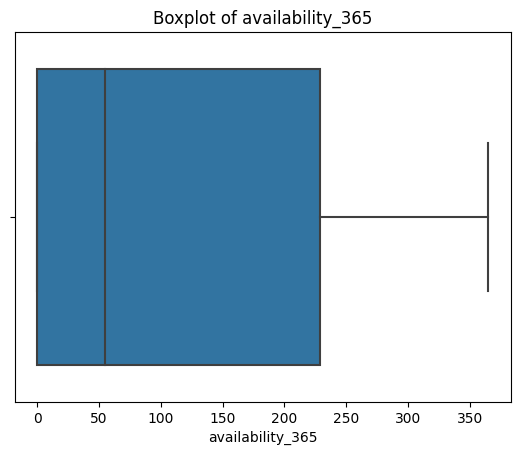

In [ ]:
columns_to_check = ['minimum_nights', 'number_of_reviews', 'calculated_host_listings_count', 'reviews_per_month', 'availability_365',]

# Creating boxplots for each column
for column in columns_to_check:
    sns.boxplot(x=listings[column])
    plt.title(f"Boxplot of {column}")
    plt.xlabel(column)
    plt.show()

There are a lot of outliers in some columns, to combat that we are taking a subset of the original dataset as follows:
1. minimum_nights < 90
2. calculated_host_listings_count < 150
3. number_of_reviews < 250
4. availability_365 < 365

In [ ]:
listings = listings.loc[
    (listings["minimum_nights"] < 90) &
    (listings['calculated_host_listings_count'] < 150) &
    (listings['number_of_reviews'] < 250) &
    (listings['availability_365'] < 365) &
    (listings['price'] > 0)
]

## 4.2 Checking the columns after subsetting the df

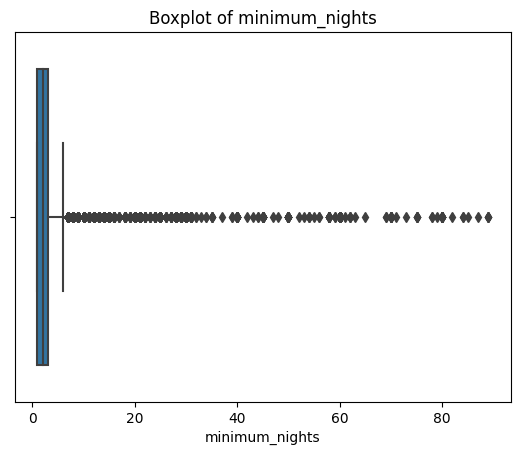

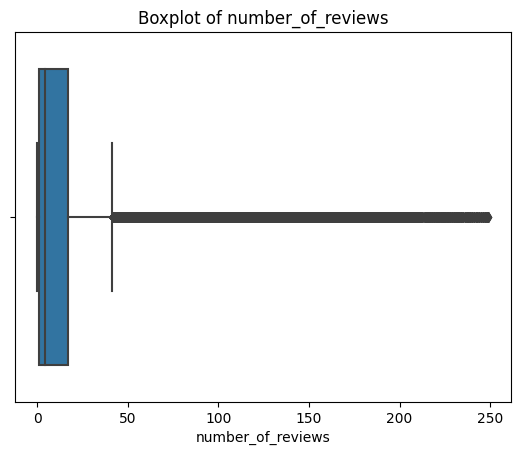

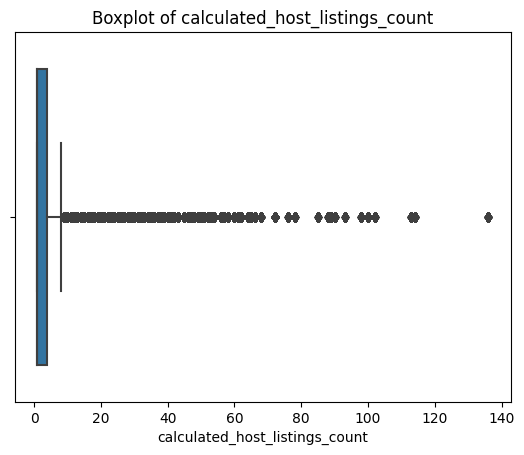

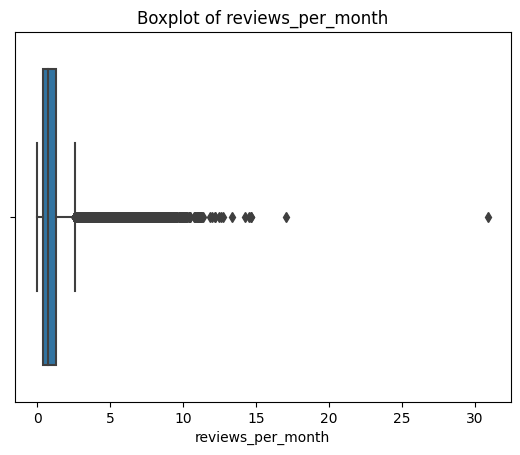

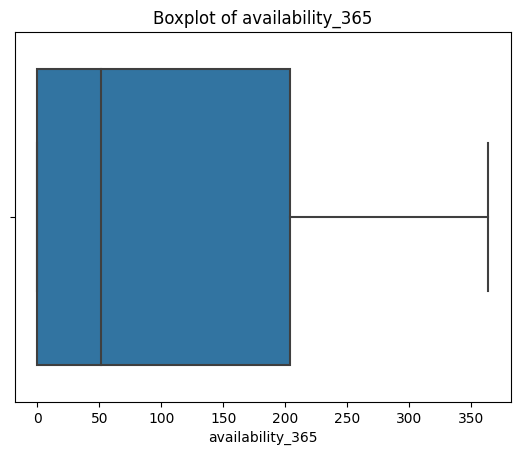

In [ ]:
columns_to_check = ['minimum_nights', 'number_of_reviews', 'calculated_host_listings_count', 'reviews_per_month', 'availability_365',]
# Creating boxplots for each column
for column in columns_to_check:
    sns.boxplot(x=listings[column])
    plt.title(f"Boxplot of {column}")
    plt.xlabel(column)
    plt.show()

A little bit better but there are still many outliers in some of the columns.

# 5. EDA to Understand our Dataset

## 5.1 Average Price per Night by Neighborhood in London
The graph below shows the average price per night for each neighborhood in London. Westminster, Kensington and Chelsea, and City of London are the three most priciest neighborhoods.

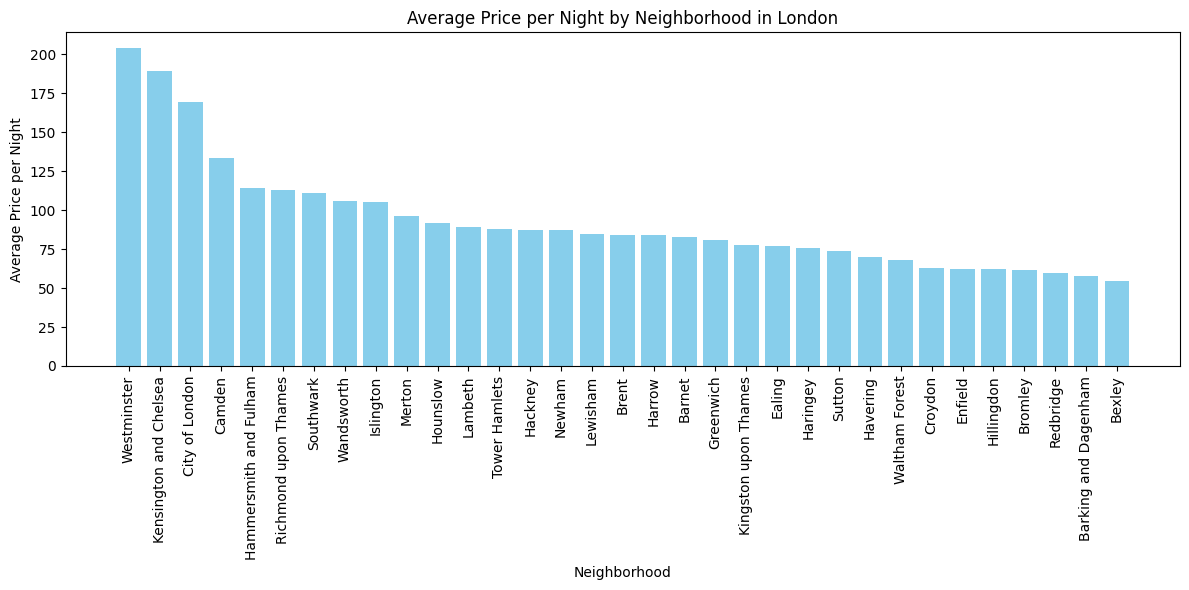

In [ ]:
neighborhood_avg_price = listings.groupby('neighbourhood')['price'].mean().reset_index()
neighborhood_avg_price = neighborhood_avg_price.sort_values('price', ascending=False)
plt.figure(figsize=(12, 6))
plt.bar(neighborhood_avg_price['neighbourhood'], neighborhood_avg_price['price'], color='skyblue')
plt.xlabel('Neighborhood')
plt.ylabel('Average Price per Night')
plt.title('Average Price per Night by Neighborhood in London')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## 5.2 Most Popular Neighborhood for Airbnb Listings in London
The graph below shows the number of listings by Neighborhood. The most popular neighborhoods are Westminster, Tower of Hamlets, and Hackney.

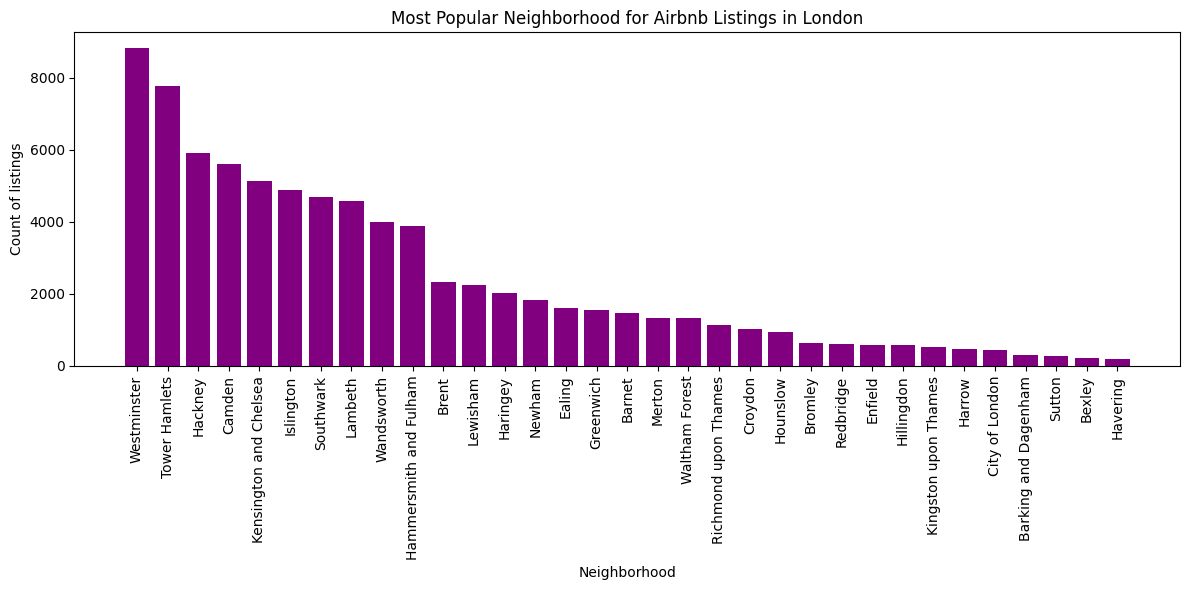

In [ ]:
popular_neighborhood = listings.groupby('neighbourhood')['price'].count().reset_index()
popular_neighborhood = popular_neighborhood.sort_values('price', ascending=False)
popular_neighborhood.head()
plt.figure(figsize=(12, 6))
plt.bar(popular_neighborhood['neighbourhood'], popular_neighborhood['price'], color='purple')
plt.xlabel('Neighborhood')
plt.ylabel('Count of listings')
plt.title('Most Popular Neighborhood for Airbnb Listings in London')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

## 5.3 Density Map of Airbnb Listings in London
The map below is an interactive map that can be used to see the most popular neighborhoods for airbnbs in London geographically. The CBD is clearly most popular and as it gets farther away from central London we see fewer listings.

In [ ]:
fig = px.density_mapbox(listings,
                        lat='latitude',
                        lon='longitude',
                        radius=10,  # Adjust the radius for point density
                        center=dict(lat=51.5074, lon=-0.1278),  # Center the map around London
                        zoom=10,  # Adjust the initial zoom level
                        width=1000,
                        height=900,
                        mapbox_style="carto-positron",  # You can choose different mapbox styles
                        range_color=[0,10],
                        title='Density Map of Airbnb Listings in London'
                       )
fig.show()

The map below gives a better sense of where the neighborhoods are exactly geographically, without having scroll aroundn the interactive map.

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



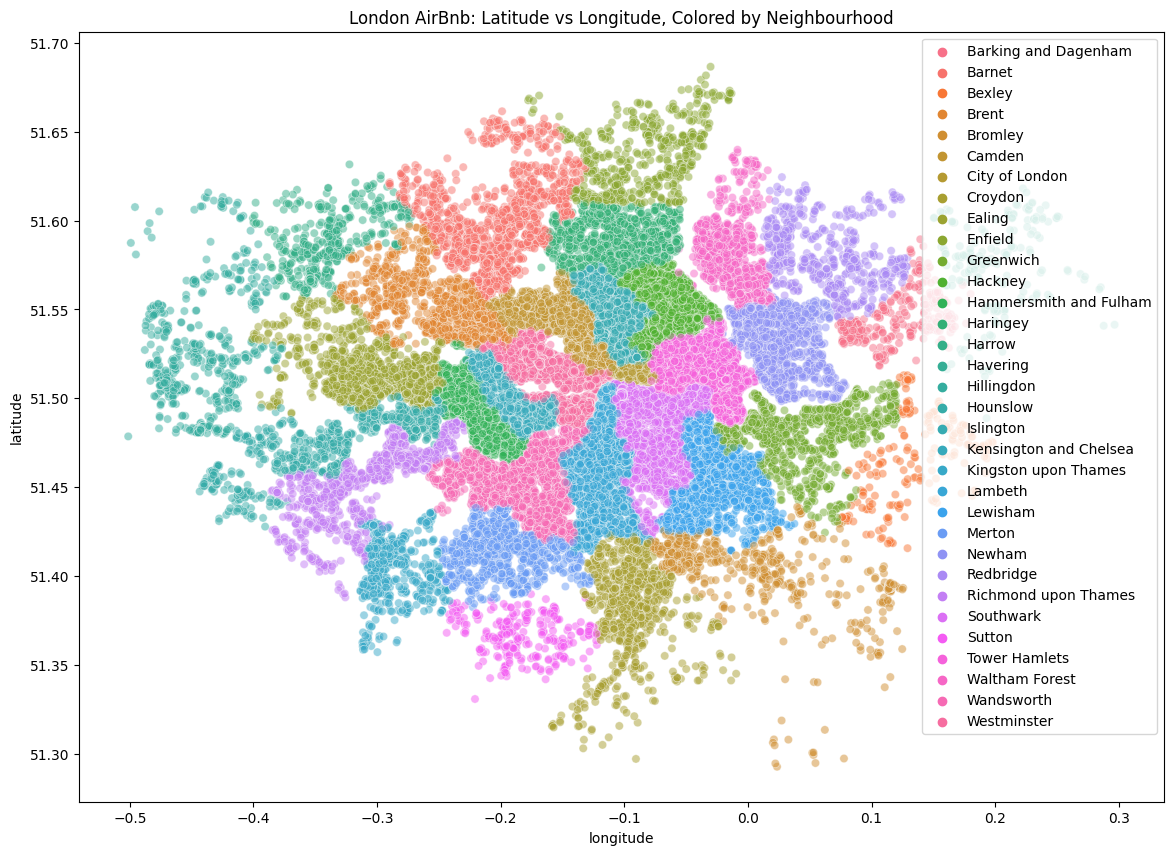

In [ ]:
plt.figure(figsize=(14,10))
sns.scatterplot(data=listings, x='longitude', y='latitude', hue='neighbourhood',alpha=0.5)
plt.title('London AirBnb: Latitude vs Longitude, Colored by Neighbourhood')
plt.legend(scatterpoints=1)
plt.show()

## 5.4 Distribution of 'room_type' by Count and Price
We want to see how many of each room_types there are to be able to make sense of the pricing (we expect entire homes to be more expensive than one room/shared rooms)

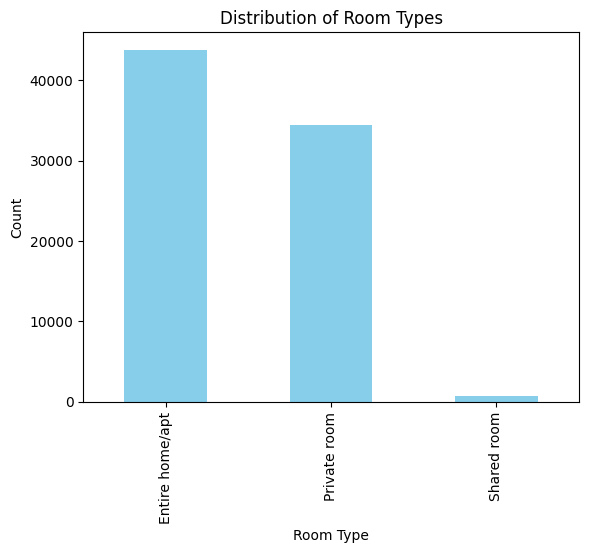

In [ ]:
room_types_count = listings['room_type'].value_counts()

# Plotting the bar graph
room_types_count.plot(kind='bar', color='skyblue')
plt.title('Distribution of Room Types')
plt.xlabel('Room Type')
plt.ylabel('Count')
plt.show()

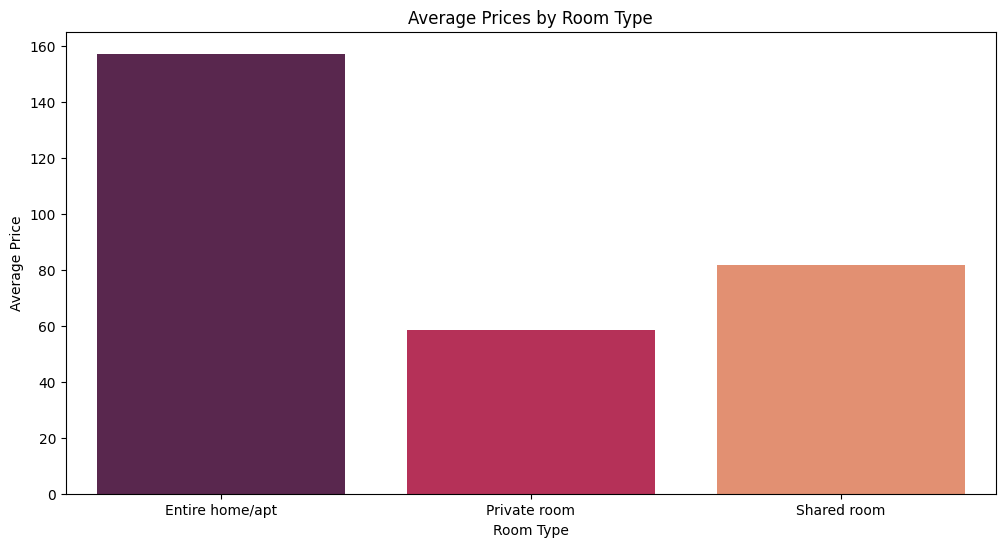

In [ ]:
average_prices = listings.groupby('room_type')['price'].mean().reset_index()

# Plotting the bar graph with average prices
plt.figure(figsize=(12, 6))
sns.barplot(x='room_type', y='price', data=average_prices, palette='rocket')
plt.title('Average Prices by Room Type')
plt.xlabel('Room Type')
plt.ylabel('Average Price')
plt.show()

Clearly we were right about entire homes being more expensive, but surprisingly shared rooms are more expensive than private rooms, which intuitively does not make sense. This is something that could affect our model because it seems to be the opposite of what pricing should be.

## 5.5 Correlation Matrix
We can see that there is a strong correlation between number_of_reviews and reviews_per_month. No other relevant columns seem to show a corrlation among each other.

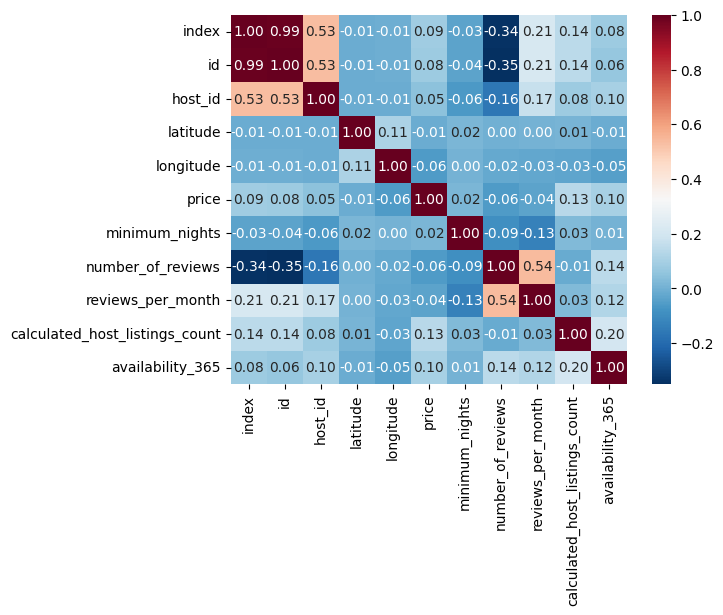

In [ ]:
corr_matrix = listings.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdBu_r');
  # annot:place the numbers in the heatmap, fmt:number of decimal, cmap: blue to red with white at 0

## 5.6 Visualize correlation through pairplots/scatter-matrices
We can see that Westminiter and Tower Hamlets have higher number of minimum nights. From previous analysis, they also tuned out to be the most expensive neighbourhoods.

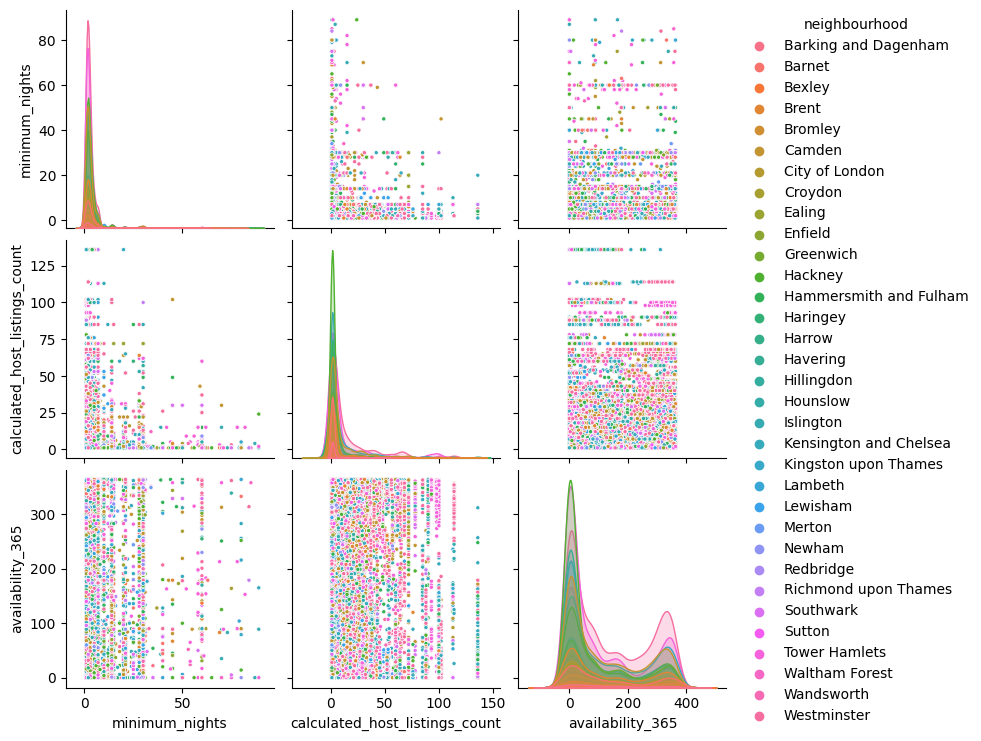

In [ ]:
attributes = ["room_type", "minimum_nights", "calculated_host_listings_count", "availability_365", "neighbourhood"]
sns.pairplot(listings[attributes], hue="neighbourhood", markers='.');

# 6. Machine Learning

## 6.1 Experimenting with Attribute Combinations

In [ ]:
listings["reviews_per_listing"] = listings["number_of_reviews"] / listings["calculated_host_listings_count"]
listings["availability_ratio"] =  listings["availability_365"] / 365

<ipython-input-100-79c12bb0c3b7>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-100-79c12bb0c3b7>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



## 6.2 Creating a Test Set

In [ ]:
X = listings.drop("price", axis=1)
y = listings["price"].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## 6.3 Prepare Data Processing for Machine Learning

### 6.3.1 Visualizing the Attribute Combinations

In [ ]:
X_train_copy = X_train.copy()  # Making a copy of the training data
y_train_copy = y_train.copy()

# Hypothetical combinations based on Airbnb columns
X_train_copy["reviews_per_listing"] = X_train_copy["number_of_reviews"] / X_train_copy["calculated_host_listings_count"]
X_train_copy["availability_ratio"] =  X_train_copy["availability_365"] / 365

# Viewing the newly created features
X_train_copy[["reviews_per_listing", "availability_ratio"]].head()

,reviews_per_listing,availability_ratio
34206,21.00000,0.00000
58058,0.80000,0.73699
40548,0.00000,0.00000
43706,3.00000,0.00000
32484,14.00000,0.93425


### 6.3.2 Creating a Cluster Similarity Function

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    # Inherits BaseEstimator to use as a custom scikit-learn estimator, gaining methods like set_params and get_params.
    # Inherits TransformerMixin for compatibility with scikit-learn pipelines and the fit_transform method.
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        # Initializes the custom transformer with default parameters for clustering and RBF kernel.
        self.n_clusters = n_clusters  # Number of clusters to form.
        self.gamma = gamma  # Coefficient for RBF.
        self.random_state = random_state  # Random state for reproducibility.

    def fit(self, X, y=None, sample_weight=None):
        # Fit method to perform k-means clustering on X.
        # Creates a KMeans instance with the specified number of clusters and random state.
        self.kmeans_ = KMeans(self.n_clusters, n_init='auto', random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)  # Fits the KMeans model to the data.
        return self  # Returns self to allow method chaining.

    def transform(self, X):
        # Transform method to calculate the RBF kernel between X and the k-means cluster centers.
        # This method effectively computes the similarity of each sample in X to each cluster center.
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None):
        # Provides output feature names for the transformation, aiding in interpretability.
        # Useful when the transformed data is passed to other estimators or inspected.
        return [f"Cluster {i} similarity" for i in range(self.n_clusters)]

### 6.3.3 Creating a Custom Transformer for Log Transformations to Reduce Impact of Outliers

In our data exploration, the boxplot analysis revealed skewed distributions and numerous outliers across our features. To mitigate the impact of outliers, we employed a log transformation, aiming to normalize the distributions. This transformation helped bring our data closer to a normal distribution, preparing it for modeling.

In [ ]:
# Create a custom transformer for log transformation
def log_transform(X):
    X_transformed = X.copy()
    # Select numerical columns for log transformation
    num_cols = ['minimum_nights', 'number_of_reviews', 'calculated_host_listings_count', 'availability_365']

    # Apply log transformation to selected columns
    X_transformed[num_cols] = np.log1p(X_transformed[num_cols])
    return X_transformed

log_transformer = FunctionTransformer(log_transform)

cluster_simil = ClusterSimilarity(n_clusters=8, gamma=1., random_state=42)

### 6.3.4 Defining the Preprocessing Pipelines with the Cluster Similarity Function, Log Transformer and Attribute Combinations

In [ ]:
# Define the preprocessing pipeline with log transformation
cat_attribs = ['neighbourhood', 'room_type']
num_attribs = ['minimum_nights', 'number_of_reviews', 'calculated_host_listings_count', 'availability_365', "availability_ratio", "reviews_per_listing"]

preprocess_pipeline = ColumnTransformer([
    ("cat", OneHotEncoder(drop="first", handle_unknown='ignore'), cat_attribs),
    ("log_transform", log_transformer, num_attribs),
    ("num", StandardScaler(), num_attribs),
    ("geo", cluster_simil, ['longitude', 'latitude'])
])

preprocess_pipeline

ColumnTransformer(transformers=[('cat',
                                 OneHotEncoder(drop='first',
                                               handle_unknown='ignore'),
                                 ['neighbourhood', 'room_type']),
                                ('log_transform',
                                 FunctionTransformer(func=<function log_transform at 0x7d231bedf2e0>),
                                 ['minimum_nights', 'number_of_reviews',
                                  'calculated_host_listings_count',
                                  'availability_365', 'availability_ratio',
                                  'reviews_per_listing']),
                                ('num', StandardScaler(),
                                 ['minimum_nights', 'number_of_reviews',
                                  'calculated_host_listings_count',
                                  'availability_365', 'availability_ratio',
                                  'reviews_per_listing']),
                                ('geo',
                                 ClusterSimilarity(n_clusters=8,
                                                   random_state=42),
                                 ['longitude', 'latitude'])])

## 6.4 Models

### 6.4.1 Linear Regression and Cross Validation

In [ ]:
lin_reg = make_pipeline(preprocess_pipeline, LinearRegression())
lin_reg.fit(X_train, y_train)
lr_y_train_predictions = lin_reg.predict(X_train)

# scoring the predictions on the training set
lr_rmse = mean_squared_error(y_train, lr_y_train_predictions, squared=False)
print(f'RMSE for Linear Regression: {lr_rmse}')

RMSE for Linear Regression: 184.86281515998334


In [ ]:
lin_cv_rmses = -cross_val_score(lin_reg, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5)
print(f"Average Linear Regression Cross-Validation RMSE: {lin_cv_rmses.mean():.2f}")

Average Linear Regression Cross-Validation RMSE: 182.24


Our initial approach involved setting up a pipeline, with linear regression chosen as the base model. Upon running the linear regression model, we obtained an RMSE (Root Mean Square Error) of 184.86. Subsequently, employing cross-validation techniques yielded a marginal improvement, reducing the RMSE to 182.24.

### 6.4.2 Ridge Pipeline and Cross Validation

In [ ]:
# Define the full pipeline with the regression model
ridge_pipeline = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('regression', Ridge(alpha=1.0))
])

# Train the Ridge model using the training set
ridge_pipeline.fit(X_train, y_train)

# Make predictions on the testing set
y_pred_ridge = ridge_pipeline.predict(X_train)

# Evaluate the Ridge model
rmse_ridge = mean_squared_error(y_train, y_pred_ridge, squared=False)
print(f'RMSE for Ridge Regression: {rmse_ridge}')

RMSE for Ridge Regression: 184.98896501874734


In [ ]:
ridge_cv_rmses = -cross_val_score(ridge_pipeline, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5)
print(f"Average Ridge Regression Cross-Validation RMSE: {ridge_cv_rmses.mean():.2f}")

Average Ridge Regression Cross-Validation RMSE: 182.36


Given the potential for overfitting in linear regression, we proceeded to explore Ridge Regression, leveraging its L2 regularization to penalize large coefficients. Surprisingly, the RMSE from Ridge Regression closely mirrored that of the linear regression model. Cross-validation on Ridge Regression reiterated a similar RMSE, suggesting limited overfitting and minimal regularization effects.

### 6.4.3 Lasso Pipeline and Cross Validation

In [ ]:
lasso_pipeline = Pipeline([
    ('preprocessing', preprocess_pipeline),
    ('regression', Lasso(alpha=1.0))
])

# Train the Lasso model using the training set
lasso_pipeline.fit(X_train, y_train)

# Make predictions on the testing set
y_pred_lasso = lasso_pipeline.predict(X_train)

# Calculate error metrics for Lasso
rmse_lasso = mean_squared_error(y_train, y_pred_lasso, squared=False)
print(f'RMSE for Lasso: {rmse_lasso}')

RMSE for Lasso: 185.72221026714934


In [ ]:
lasso_cv_rmses = -cross_val_score(lasso_pipeline, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5)
print(f"Average Lasso Regression Cross-Validation RMSE: {lasso_cv_rmses.mean():.2f}")

Average Lasso Regression Cross-Validation RMSE: 183.09


Seeking to address outliers, we experimented with Lasso Regression, but observed no significant improvement in our RMSE. In fact, the RMSE from Lasso Regression slightly surpassed that of both Linear and Ridge Regression models.

**Summary:**
1. For the base models, Linear Regression has the lowest RMSE, followed by Ridge and then Lasso.
2. Trying cross-validation with cv=5 vs. cv=3 appeared to give better results, with the RMSE scores for all 3 models decreasing, but not by much.

 ### 6.4.4 KNN Regressor and Cross Validation

In [ ]:
# Define the KNN regressor
knn_regressor = KNeighborsRegressor(n_neighbors=5)

full_pipeline = Pipeline([
    ("preprocess", preprocess_pipeline),
    ("regressor", knn_regressor),
])

# Train the entire pipeline on the training data
full_pipeline.fit(X_train, y_train)

# Make predictions on the test set
knn_y_pred = full_pipeline.predict(X_train)

# Evaluate the performance of the model
rmse_knn = mean_squared_error(y_train, knn_y_pred, squared=False)
print(f"Root Mean Squared Error on the test set: {rmse_knn}")

Root Mean Squared Error on the test set: 151.87474462210088


In [ ]:
knn_cv_rmses = -cross_val_score(full_pipeline, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5)
print(f"Average KNN Regression Cross-Validation RMSE: {knn_cv_rmses.mean():.2f}")

Average KNN Regression Cross-Validation RMSE: 192.43


Transitioning to alternative models, KNeighbors Regressor (KNR) emerged as a standout performer, delivering an RMSE of approximately 151.87, surpassing the performance of the previous three models. However, cross-validation on KNR resulted in a higher RMSE of about 192.43, indicating potential overfitting in this model.

**Summary:** KNN Regressor performed better than the Linear Regression/Ridge/Lasso models without cross-validation, as KNN's RMSE went up and beyond that of the other models shown until now.

### 6.4.5 Random Forest and Cross Validation

In [ ]:
rf_pipeline = Pipeline([
    ('preprocessor', preprocess_pipeline),
    ('model', RandomForestRegressor())
])

# Fit the model
rf_pipeline.fit(X_train, y_train)

rf_predictions = rf_pipeline.predict(X_train)

# Evaluate model performance
rmse_rf = mean_squared_error(y_train, rf_predictions, squared=False)
print(f"Root Mean Squared Error: {rmse_rf}")

Root Mean Squared Error: 65.44187441716466


In [ ]:
rf_cv_rmses = -cross_val_score(rf_pipeline, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5)
print(f"Average Random Forest Regression Cross-Validation RMSE: {rf_cv_rmses.mean():.2f}")

Average Random Forest Regression Cross-Validation RMSE: 175.70


In [ ]:
rf_r2 = r2_score(y_train, rf_predictions)
print(f"R^2 Score: {rf_r2:.4f}")

R^2 Score: 0.8893


Moving forward, the Random Forest Regressor stood out as our most promising model, showcasing a notably lower RMSE of 65.44. Yet, attempts at improving this model's performance via cross-validation led to a slight deterioration, with the RMSE rising to 175.70.

**Summary:**
Random Forest base model appears to perform the best so far, as it has the lowest rmse. The rmse is increasing after cross validation. Though we are not consistently comparing the R squared value across all models, Random Forest does seem to have the best R squared value.

### 6.4.6 XGB Regressor and Cross Validation

In [ ]:
model_xg = XGBRegressor(n_estimators=100,
                         max_leaves=16,
                         learning_rate=0.1,
                         objective='reg:squarederror') # learning a binary classifier, produce probability as score

xgb_pipeline = Pipeline([
    ('preprocessor', preprocess_pipeline),
    ('model', model_xg)
])

# Fit the model
xgb_pipeline.fit(X_train, y_train)

xgb_predictions = xgb_pipeline.predict(X_train)

# Evaluate model performance
rmse_xgb = mean_squared_error(y_train, xgb_predictions, squared=False)
print(f"Root Mean Squared Error on the train set: {rmse_xgb}")

Root Mean Squared Error on the train set: 142.19532040407483


In [ ]:
xgb_cv_rmses = -cross_val_score(xgb_pipeline, X_train, y_train, scoring="neg_root_mean_squared_error", cv=5)
print(f"Average XGB Regression Cross-Validation RMSE: {xgb_cv_rmses.mean():.2f}")

Average XGB Regression Cross-Validation RMSE: 179.69


**Summary:** The XGB Regressor performed second best so far if comparing the base models, it seems that the cross validation is increasing the rmse for all models thus far. We expect it to do the same for SVM.

### 6.4.7 SVM and Cross Validation

Choosing to convert the latitude and longitude to 'geohash' variables to see if it performs better.  

In [ ]:
def create_geohash(row):
    return gh.encode(row['latitude'], row['longitude'], precision=4)
listings['geohash'] = listings.apply(create_geohash, axis=1)
print(listings[['latitude', 'longitude', 'geohash']])

       latitude  longitude geohash
0      51.56802   -0.11121    gcpv
1      51.48796   -0.16898    gcpu
2      51.52098   -0.14002    gcpv
3      51.47298   -0.16376    gcpu
4      51.44687   -0.21874    gcpu
...         ...        ...     ...
83845  51.53057   -0.18423    gcpv
83846  51.52301   -0.08979    gcpv
83847  51.52301   -0.08979    gcpv
83848  51.52301   -0.08979    gcpv
83849  51.51050   -0.01788    gcpv

[78894 rows x 3 columns]


<ipython-input-119-457b43a5140d>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [ ]:
# Choose your SVM kernel and set up the model
svm_model = SVR(kernel='rbf', C=1000, gamma=0.001)

# Create the final pipeline
svm_pipeline = Pipeline([
    ('preparation', preprocess_pipeline),
    ('svm_model', svm_model)
])

# Display the pipeline
svm_pipeline

Pipeline(steps=[('preparation',
                 ColumnTransformer(transformers=[('cat',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore'),
                                                  ['neighbourhood',
                                                   'room_type']),
                                                 ('log_transform',
                                                  FunctionTransformer(func=<function log_transform at 0x7d231bedf2e0>),
                                                  ['minimum_nights',
                                                   'number_of_reviews',
                                                   'calculated_host_listings_count',
                                                   'availability_365',
                                                   'availability_ratio',
                                                   'reviews_per_listing']),
                                                 ('num', StandardScaler(),
                                                  ['minimum_nights',
                                                   'number_of_reviews',
                                                   'calculated_host_listings_count',
                                                   'availability_365',
                                                   'availability_ratio',
                                                   'reviews_per_listing']),
                                                 ('geo',
                                                  ClusterSimilarity(n_clusters=8,
                                                                    random_state=42),
                                                  ['longitude', 'latitude'])])),
                ('svm_model', SVR(C=1000, gamma=0.001))])

To train the model I am taking a subset of the dataset because it is taking a veyr long time to run the model for SVM.

In [ ]:
# Train the model
svm_pipeline.fit(X_train[:10000], y_train[:10000])

# Make predictions on the test set
y_pred_svm = full_pipeline.predict(X_train)

rmse_svm = mean_squared_error(y_train, y_pred_svm, squared=False)

print(f"Root Mean Squared Error on the train set: {rmse_svm}")


Root Mean Squared Error on the train set: 164.36644779979503


In [ ]:
svm_cv_rmses = -cross_val_score(svm_pipeline, X_train[:10000], y_train[:10000], scoring="neg_root_mean_squared_error", cv=5)
print(f"Average SVM Regression Cross-Validation RMSE: {svm_cv_rmses.mean():.2f}")

Average SVM Regression Cross-Validation RMSE: 202.38


**Summary:** SVM has the highest rmse and also did not perform better with cross validaiton. We will definitely not be using this model.

Comparatively, the XGBoost Regressor and SVM Regressor achieved RMSE values of 142.19 and 164.36, respectively. However, cross-validation on these models indicated increased RMSE values of 179.69 and 202.38, respectively. Hence, after rigorous evaluation and comparison, the Random Forest Regressor emerged as our best-performing model, offering the lowest RMSE among all models assessed.

# 7. Hyperparameter Tuning: Randomized Search
For hyperparameter tuning, we have chosen to move forward with Random Forest and XGB as they were our best base models.

We have chosen randomized search for hyperparameter tuning for multiple reasons:
- We feel that the dataset involves various types of features, and the models used for predicting housing prices could have multiple hyperparameters and since randomized search is particularly advantageous when dealing with a large and commplex hyperparameter space
- There are a lot of nonlinear relationships in our dataset and randomized search is better suited for exploring those relationships
- Employing the RandomizedSearchCV technique, our goal was to fine-tune these models by discovering the most optimal parameters, thereby potentially reducing our RMSE.

## 7.1 XGB

In [ ]:
# Create the XGBoostRegressor model
model_xg = XGBRegressor(n_estimators=100,
                         max_leaves=16,
                         learning_rate=0.1,
                         objective='reg:squarederror')

# Create the XGBoost pipeline
xgb_pipeline = Pipeline([
    ('preprocessor', preprocess_pipeline),
    ('model', model_xg)
])

param_distributions = {
    'model__n_estimators': randint(50, 300),
    'model__max_depth': randint(3, 10),
    'model__learning_rate': uniform(0.01, 0.5),  # Generating float values between 0.01 and 0.51
    'model__subsample': [0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.8, 0.9, 1.0],
    'model__reg_alpha': [0, 0.1, 0.5, 1.0],
    'model__reg_lambda': [0, 0.1, 0.5, 1.0]
}

# Create the RandomizedSearchCV object
xgb_random_search = RandomizedSearchCV(
    xgb_pipeline,
    param_distributions=param_distributions,
    n_iter=10,  # Adjust the number of iterations as needed
    cv=5,       # Adjust the number of cross-validation folds as needed
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

# Fit the RandomizedSearchCV object to the data
xgb_random_search.fit(X_train, y_train)

# Get the best estimator from the search
xgb_best_model = xgb_random_search.best_estimator_

# Make predictions on the test set using the best model
xgb_best_predictions = xgb_best_model.predict(X_train)

# Evaluate model performance
rmse_xgb = mean_squared_error(y_train, xgb_best_predictions, squared=False)
print(f"Root Mean Squared Error on the train set: {rmse_xgb}")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Root Mean Squared Error on the train set: 163.74254211548296


**Summary:** The rmse actually increased after hyperparameter tuning.

## 7.2 Random Forest

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import randint

model = RandomForestRegressor(n_estimators=100, min_samples_leaf= 1, random_state=25)

# Define the Random forest and its hyperparameters
param_distribs = {
    'model__max_depth': randint(1, 20),  # Random integer values between 1 and 20 for max_depth
    'model__min_samples_split': randint(2, 20),  # Random integer values between 2 and 20 for min_samples_split

}

# Create a Pipeline including preprocessing and DecisionTreeRegressor model
rf2_pipeline = Pipeline([
    ('preprocessor', preprocess_pipeline),
    ('model', RandomForestRegressor())  # The 'model' refers to the DecisionTreeRegressor instance
])

# Create RandomizedSearchCV object
random_search = RandomizedSearchCV(rf2_pipeline, param_distributions=param_distribs, n_iter=10, cv=3,
                                   scoring='neg_root_mean_squared_error', random_state=42)

# Fit the RandomizedSearchCV to the training data
random_search.fit(X_train, y_train)

# Get the best estimator from the search
best_estimator = random_search.best_estimator_

# Get the results of cross-validation
random_cv_res = pd.DataFrame(random_search.cv_results_)

# Display top results based on mean_test_score
random_cv_res.sort_values(by='mean_test_score', ascending=False, inplace=True)
random_cv_res[['param_model__max_depth', 'param_model__min_samples_split', 'mean_test_score']].head()


,param_model__max_depth,param_model__min_samples_split,mean_test_score
8,12,18,-180.14770
9,10,17,-181.22508
0,7,16,-184.30684
2,7,12,-185.77002
5,2,13,-186.71678


In [ ]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=100, min_samples_leaf= 1, max_depth=12, min_samples_split=18, random_state=25)

rf_pipeline = Pipeline([
    ('preprocessor', preprocess_pipeline),
    ('model', model)
])

# Fit the model
rf_pipeline.fit(X_train, y_train)

rf_predictions = rf_pipeline.predict(X_train)


# Evaluate model performance
rmse_rf = mean_squared_error(y_train, rf_predictions, squared=False)
print(f"Root Mean Squared Error: {rmse_rf}")

Root Mean Squared Error: 138.93242777308143


**Summary:** Surprisingly, after completing the hyperparameter tuning process, we observed an unexpected outcome: the RMSE for both models increased. This result was unexpected and rather unhelpful as the tuning did not yield the anticipated improvements in model performance. We will still be using Random Forest as the base model showed us the smallest rmse value. However, based on how cross validation and hyperparameter tuning have gone, we expect that this model will not work very well on unseen data. We fear that our model is overfitting to the data too much.

## 7.3 Voting
Voting combines the predictions of multiple models to improve overall performance. We attempted to apply the voting technique on different types of regression models - linear, tree-based and distance based, so that different aspects of the data could be captured, and biases present in the individual models could possibly be mitigated.
We got an RMSE of 108.54 for our Voting Regressor based on the models above, which was significantly lower than the RMSE scores for most of the individual models. However, ultimately, the Random Forest Regressor had the lowest RMSE score, so we chose that as our final model to predict our test dataset on.

In [ ]:
from sklearn.ensemble import VotingRegressor

# Define the preprocessing pipeline with log transformation
cat_attribs = ['neighbourhood', 'room_type']
num_attribs = ['minimum_nights', 'number_of_reviews', 'calculated_host_listings_count', 'availability_365', "availability_ratio", "reviews_per_listing"]

preprocess_pipeline = ColumnTransformer([
    ("cat", OneHotEncoder(drop="first", handle_unknown='ignore'), cat_attribs),
    ("log_transform", log_transformer, num_attribs),
    ("num", StandardScaler(), num_attribs),
    ("geo", cluster_simil, ['longitude', 'latitude'])
])

# Create base regression models
rf_reg = RandomForestRegressor()
xgb_reg = XGBRegressor()
knn_reg = KNeighborsRegressor()
linear_reg = LinearRegression()

# Create a Voting Regressor with the preprocessing pipeline
voting_reg = VotingRegressor(estimators=[
    ('rf', Pipeline([('preprocessor', preprocess_pipeline), ('model', rf_reg)])),
    ('xgb', Pipeline([('preprocessor', preprocess_pipeline), ('model', xgb_reg)])),
    ('knn', Pipeline([('preprocessor', preprocess_pipeline), ('model', knn_reg)])),
    ('linear', Pipeline([('preprocessor', preprocess_pipeline), ('model', linear_reg)]))
])

# Fit the ensemble model
voting_reg.fit(X_train, y_train)

# Make predictions
predictions = voting_reg.predict(X_train)

# Calculate Mean Squared Error
mse = mean_squared_error(y_train, predictions)

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)

print(f"Voting Regressor Mean Squared Error: {mse}")
print(f"Voting Regressor Root Mean Squared Error: {rmse}")

Voting Regressor Mean Squared Error: 11781.717270146728
Voting Regressor Root Mean Squared Error: 108.54361920512291


# 8. Evaluating Chosen Model on Test Set

## 8.1 Using Voting to Predict on Test Set

In [ ]:
final_predictions = voting_reg.predict(X_test)
final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(f'The RMSE of the selected model {final_rmse:.0f}.')

The RMSE of the selected model 173.


## 8.2 Using Random Forest to Predict on Test Set

In [ ]:
final_predictions = rf_pipeline.predict(X_test)
final_rmse = mean_squared_error(y_test, final_predictions, squared=False)
print(f'The RMSE of the selected model {final_rmse:.0f}.')

The RMSE of the selected model 180.


In our project to predict housing prices for Airbnb listings, we decided two primary models: a Random Forest Regressor and a Voting Regressor. The analysis focused on evaluating their performance on both the training set and the test set.
* Random Forest Model:
    * On the training set, the base Random Forest Regressor exhibited promising performance with an RMSE of 65. However, when evaluated on the test set, the RMSE increased significantly to 180. This stark rise indicates potential overfitting, suggesting that the model may have learned noise or patterns specific to the training data that do not generalize well.
* Voting Regressor:
    * The Voting Regressor, combining predictions from Random Forest, XGBoost, and K-Nearest Neighbors, initially showed a training set RMSE of 108. However, on the test set, the RMSE increased to 173. This performance drop, while not as dramatic as the Random Forest model, still indicates challenges in generalizing to unseen data.

In conclusion, our project highlights the importance of addressing overfitting and refining model hyperparameters.